https://towardsdatascience.com/markov-chain-analysis-and-simulation-using-python-4507cee0b06e
https://www.stat.auckland.ac.nz/~fewster/325/notes/ch8.pdf
https://rstudio-pubs-static.s3.amazonaws.com/136018_2d1e15ca17984bd79236b4964dfb93f9.html
https://python.quantecon.org/finite_markov.html
https://arxiv.org/pdf/2001.07824.pdf

In [237]:
from pymc3.gp.util import plot_gp_dist

In [238]:
def scaleX(x):
    return list(x/np.sum(x))

def rBeta(a,b):
    return np.random.beta(a,b)

def markovChain(state, M, N = 100, P0 = []):
    stateHist=state
    dfStateHist=pd.DataFrame(state)
    distr_hist = [[0,0,0]]
    burned_black = np.array([0])
    new_green = np.array([0]) 
    
    for x in range(N):
        P = genTransMatrix() if len(P0) == 0 else P0
        #P = genTransMatrix() 
        P_scale = np.multiply(P,M)
        state = np.dot(state,P_scale)
        stateHist=np.append(stateHist,state,axis=0)
        
        burned_black = np.append(burned_black, P[0,2]*state[0,0] + P[1,2]*state[0,1])
        new_green = np.append(new_green, P[1,0]*state[0,1] + P[2,0]*state[0,2])
    
    dfDistrHist = pd.DataFrame(stateHist)    
    dfDistrHist.columns = ['Green', 'NFT', 'Burned'] 
    dfDistrHist.insert(3, "burned_black", burned_black, True)
    dfDistrHist.insert(4, "tot_burned_black", np.cumsum(burned_black), True)
    dfDistrHist.insert(5, "new_green", new_green, True)
    dfDistrHist.insert(6, "tot_minted_green", np.cumsum(new_green), True)
        
    return dfDistrHist   

def genTransMatrix():
    P = np.array([[rBeta(9,1), rBeta(1,19), rBeta(1,19)],
              [rBeta(1,19), rBeta(9,1), rBeta(1,19)],
              [0.01, 0, 0.99]])

    return np.array(list(map(scaleX, P)))   

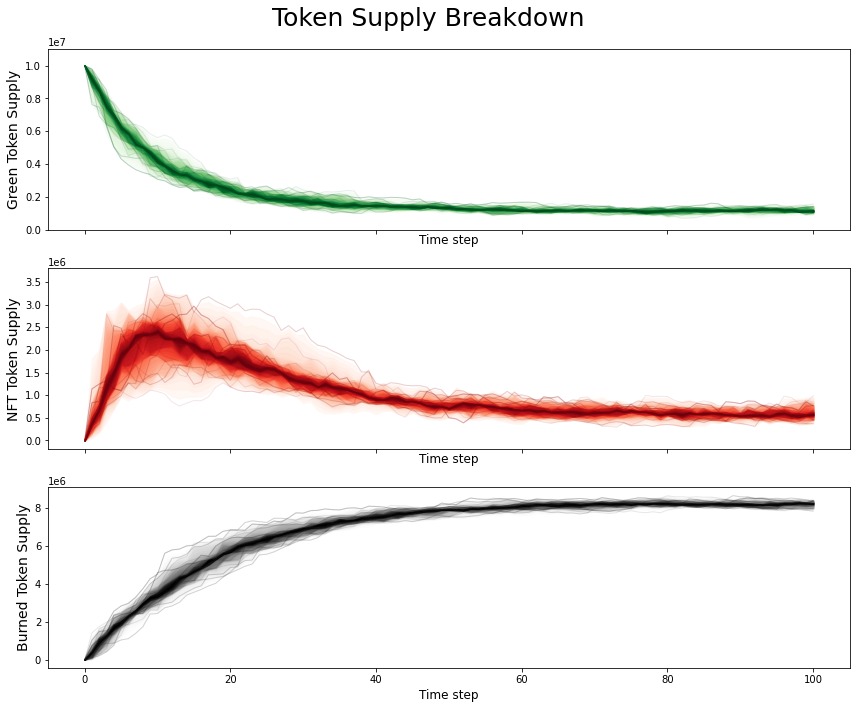

In [239]:
import numpy as np
import pandas as pd
from random import seed
from random import random
import matplotlib.pyplot as plt

N = 100
M = np.repeat(1,9).reshape((3, 3)); M[1,0] = 1
state=np.array([[1e7, 0.0, 0.0]])

dfDistrHist = markovChain(state, M, N)
green = dfDistrHist.Green.values.reshape(-1,1)
nft = dfDistrHist.NFT.values.reshape(-1,1)
burned = dfDistrHist.Burned.values.reshape(-1,1)
burned_tot = dfDistrHist.tot_burned_black.values.reshape(-1,1)
tot_minted = dfDistrHist.tot_minted_green.values.reshape(-1,1)
new_black = dfDistrHist.burned_black.values.reshape(-1,1)
new_green = dfDistrHist.new_green.values.reshape(-1,1)

for k in range(1,25):
    dfDistrHist = markovChain(state, M, N)
    green = np.hstack((green, dfDistrHist.Green.values.reshape(-1,1)))
    nft = np.hstack((nft, dfDistrHist.NFT.values.reshape(-1,1)))
    burned = np.hstack((burned, dfDistrHist.Burned.values.reshape(-1,1)))
    burned_tot = np.hstack((burned_tot, dfDistrHist.tot_burned_black.values.reshape(-1,1)))
    tot_minted = np.hstack((tot_minted, dfDistrHist.tot_minted_green.values.reshape(-1,1)))  
    new_black = np.hstack((new_black, dfDistrHist.burned_black.values.reshape(-1,1)))
    new_green = np.hstack((new_green, dfDistrHist.new_green.values.reshape(-1,1)))

fig, (green_ax, nft_ax, burned_ax) = plt.subplots(nrows=3, sharex=True, sharey=False, figsize=(12, 10))
fig.suptitle('Token Supply Breakdown', fontsize=25)
plot_gp_dist(green_ax, green.transpose(), np.array(range(0,len(green))), palette="Greens")
green_ax.set_xlabel("Time step", fontsize=12)
green_ax.set_ylabel("Green Token Supply", fontsize=14)  
green_ax.set_ylim((0,1.1e7))

plot_gp_dist(nft_ax, nft.transpose(), np.array(range(0,len(green))), palette="Reds")
nft_ax.set_xlabel("Time step", fontsize=12)
nft_ax.set_ylabel("NFT Token Supply", fontsize=14)    

plot_gp_dist(burned_ax, burned.transpose(), np.array(range(0,len(green))), palette="Greys")
burned_ax.set_xlabel("Time step", fontsize=12)
burned_ax.set_ylabel("Burned Token Supply", fontsize=14)
fig.savefig('token_supply_sims.png')
plt.tight_layout()

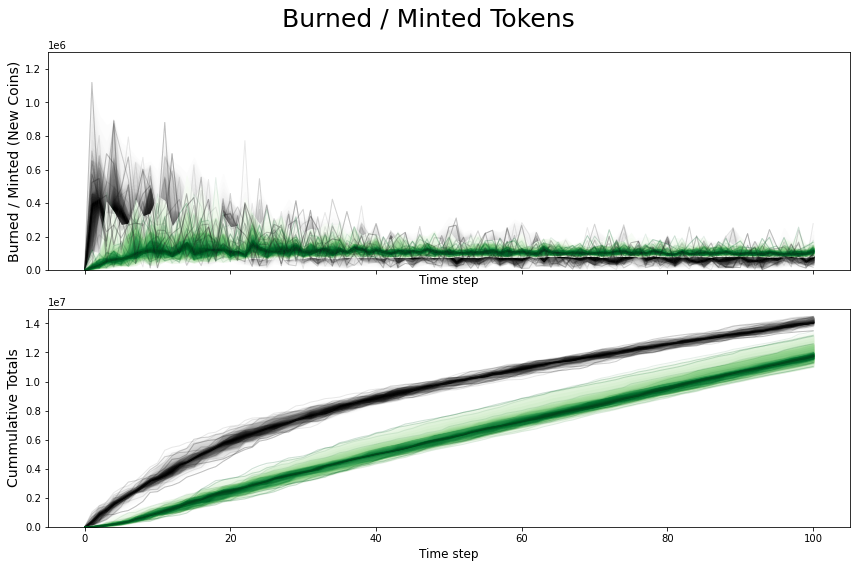

In [240]:
fig, (new_ax, tot_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(12, 8))
fig.suptitle('Burned / Minted Tokens', fontsize=25)

plot_gp_dist(new_ax, new_black.transpose(), np.array(range(0,len(green))), palette="Greys")
plot_gp_dist(new_ax, new_green.transpose(), np.array(range(0,len(green))), palette="Greens")
new_ax.set_xlabel("Time step", fontsize=12)
new_ax.set_ylabel("Burned / Minted (New Coins)", fontsize=14)  
new_ax.set_ylim((0,1.3e6))

plot_gp_dist(tot_ax, burned_tot.transpose(), np.array(range(0,len(green))), palette="Greys")
plot_gp_dist(tot_ax, tot_minted.transpose(), np.array(range(0,len(green))), palette="Greens")
tot_ax.set_xlabel("Time step", fontsize=12)
tot_ax.set_ylabel("Cummulative Totals", fontsize=14)  
tot_ax.set_ylim((0,1.5e7))
plt.tight_layout()

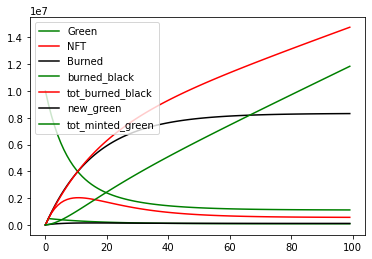

In [241]:
N = 100
P = np.array([[0.9, 0.05, 0.05],
              [0.05, 0.9, 0.05],
              [0.01, 0, .99]])
state=np.array([[1e7, 0.0, 0.0]])
dfDistrHist = markovChain(state, M, N, P)

ax = dfDistrHist.head(N).plot(color = ['green', 'red', 'black','green', 'red', 'black'])   

In [242]:
dfDistrHist.tail(10)

,Green,NFT,Burned,burned_black,tot_burned_black,new_green,tot_minted_green
91,1.124395e+06,572156.381551,8.303448e+06,84827.583923,1.408770e+07,111642.302293,1.095464e+07
92,1.123598e+06,571160.508241,8.305241e+06,84737.928888,1.417244e+07,111610.439635,1.106625e+07
93,1.122849e+06,570224.360893,8.306927e+06,84653.653154,1.425709e+07,111580.487414,1.117783e+07
94,1.122144e+06,569344.359913,8.308511e+06,84574.433965,1.434167e+07,111552.331203,1.128938e+07
95,1.121482e+06,568517.139891,8.310001e+06,84499.967927,1.442617e+07,111525.863409,1.140091e+07
96,1.120860e+06,567739.536835,8.311401e+06,84429.969851,1.451060e+07,111500.982871,1.151241e+07
97,1.120275e+06,567008.576161,8.312717e+06,84364.171660,1.459496e+07,111477.594476,1.162389e+07
98,1.119725e+06,566321.461397,8.313954e+06,84302.321361,1.467926e+07,111455.608798,1.173534e+07
99,1.119208e+06,565675.563548,8.315116e+06,84244.182079,1.476351e+07,111434.941762,1.184678e+07
100,1.118722e+06,565068.411095,8.316209e+06,84189.531154,1.484770e+07,111415.514324,1.195819e+07


In [243]:
P

array([[0.9 , 0.05, 0.05],
       [0.05, 0.9 , 0.05],
       [0.01, 0.  , 0.99]])

In [244]:
supply = pd.DataFrame({'green':np.array([1e7]), 'red':np.array([0]), 'black':np.array([0])})

burned_black = np.array([0])
new_green = np.array([0]) 

for n in range(0,100):
    prev = supply.tail(1).values.flatten()
    green_i = prev[0] + 0.05*prev[1] + 0.01*prev[2] - 0.05*prev[0] - 0.05*prev[0]
    red_i = prev[1] + 0.05*prev[0] + 0*prev[2] - 0.05*prev[1] - 0.05*prev[1]
    black_i = prev[2] + 0.05*prev[0] + 0.05*prev[1] - 0*prev[2] - 0.01*prev[2]
    update = np.array([green_i,red_i,black_i])

    burned_black = np.append(burned_black, P[0,2]*prev[0] + P[1,2]*prev[1])
    new_green = np.append(new_green, P[1,0]*prev[1] + P[2,0]*prev[2])
    
    supply = supply.append(pd.DataFrame(update.reshape(1,-1), columns=list(supply)), ignore_index=True)

supply.insert(3, "burned_black", burned_black, True)
supply.insert(4, "tot_burned_black", np.cumsum(burned_black), True)
supply.insert(5, "new_green", new_green, True)
supply.insert(6, "tot_minted_green", np.cumsum(new_green), True)
supply.tail(10)

,green,red,black,burned_black,tot_burned_black,new_green,tot_minted_green
91,1.124395e+06,572156.381551,8.303448e+06,84922.961620,1.450287e+07,111676.197084,1.084300e+07
92,1.123598e+06,571160.508241,8.305241e+06,84827.583923,1.458770e+07,111642.302293,1.095464e+07
93,1.122849e+06,570224.360893,8.306927e+06,84737.928888,1.467244e+07,111610.439635,1.106625e+07
94,1.122144e+06,569344.359913,8.308511e+06,84653.653154,1.475709e+07,111580.487414,1.117783e+07
95,1.121482e+06,568517.139891,8.310001e+06,84574.433965,1.484167e+07,111552.331203,1.128938e+07
96,1.120860e+06,567739.536835,8.311401e+06,84499.967927,1.492617e+07,111525.863409,1.140091e+07
97,1.120275e+06,567008.576161,8.312717e+06,84429.969851,1.501060e+07,111500.982871,1.151241e+07
98,1.119725e+06,566321.461397,8.313954e+06,84364.171660,1.509496e+07,111477.594476,1.162389e+07
99,1.119208e+06,565675.563548,8.315116e+06,84302.321361,1.517926e+07,111455.608798,1.173534e+07
100,1.118722e+06,565068.411095,8.316209e+06,84244.182079,1.526351e+07,111434.941762,1.184678e+07


<AxesSubplot:>

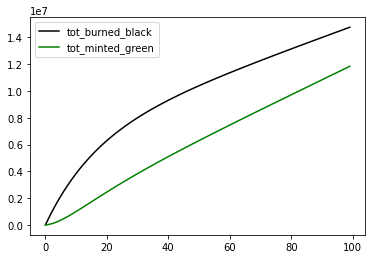

In [245]:
dfDistrHist[['tot_burned_black','tot_minted_green']].head(N).plot(color = ['black', 'green'])   

In [246]:
dfDistrHist.loc[100]

Green               1.118722e+06
NFT                 5.650684e+05
Burned              8.316209e+06
burned_black        8.418953e+04
tot_burned_black    1.484770e+07
new_green           1.114155e+05
tot_minted_green    1.195819e+07
Name: 100, dtype: float64

In [247]:
P = np.array([[0.9, 0.05, 0.05],
              [0.05, 0.9, 0.05],
              [0.01, 0, 0.99]])

A=np.append(np.transpose(P)-np.identity(3),[[1,1,1]],axis=0)
b=np.transpose(np.array([0,0,0,1]))
np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))

array([0.11111111, 0.05555556, 0.83333333])